In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import xavierUtils as xu
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import matplotlib.colors as colors 
from matplotlib.patches import Patch
import datetime as dt
%autosave 1000000

Autosaving every 1000000 seconds


In [8]:
# IMPORT CONFIGs
import os
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../scripts')
from config import RAW_PATH, TREAT_PATH, OUTPUT_PATH


# DATA ANALYSIS & VIZ TOOLS
from copy import deepcopy
import datetime as dt

import pandas as pd
pd.options.display.max_columns = 999

import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.colors as colors 
# Para legenda com linhas:
from matplotlib import lines
# Para legenda com barras:
from matplotlib.patches import Patch

import plotly
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)


# For changes in .py
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [14]:
from utils import *

### Funções

In [15]:
def fracColorF(now, mean, dev):
    if now>mean+dev:
        return 'darkturquoise'
    if now<mean+dev and now>mean-dev:
        return 'y'
    if now<mean-dev:
        return 'orangered'

In [16]:
def repeatEntryQ(series):
    u = series.unique()
    if len(series) > len(u):
        return True
    elif len(series) == len(u):
        return False
    else:
        raise Exception('len(unique) > sum(unique): shouldn\'t happen')

### Carrega dados

In [19]:
r = query_gcp('SELECT * FROM `gabinete-compartilhado.congresso.senado_proposicoes_temas`')

In [20]:
r.head(1)

,ano,numero,sigla_tipo,tema,macro_tema,data_apresentacao,casa_iniciadora,capture_date,api_url
0,1990,1,ADL,None,None,1990-06-26,Congresso Nacional,2019-05-01 11:06:55,http://legis.senado.leg.br/dadosabertos/materia/1


In [21]:
r=r.reset_index(drop=True)

In [22]:
r['id'] = r['numero']

### Exploração

In [25]:
unique(r.columns)

10:ano,  api_url,  capture_date,  casa_iniciadora,  data_apresentacao,  id,  macro_tema,  numero,  sigla_tipo,  tema


In [27]:
check_missing(r)

Colunas com valores faltantes:
       coluna      N      %
3        tema  69456  77.19
4  macro_tema  69456  77.19


In [29]:
map_unique(r)

NameError: name 'basestring' is not defined

In [30]:
one2oneQ(r,'codTema','tema')

NameError: name 'one2oneQ' is not defined

### Verifica ocorrência de proposições no mesmo período

#### Carrega e verifica dados de proposições

In [9]:
query = "SELECT * FROM `gabinete-compartilhado.camara_v2.proposicoes`"

prop = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                   dialect='standard',
                   private_key='../keys-configs/gabinete-compartilhado.json')

In [10]:
p = prop.reset_index(drop=True)
p['dataStatus'] = p.ultimoStatus.map(lambda d: d['data'])

In [11]:
xu.unique(p.columns)

20: ano | api_url | capture_date | codTipo | dataApresentacao | dataStatus | descricaoTipo | ementa | ementaDetalhada | id | keywords | numero | siglaTipo | ultimoStatus | uri | uriOrgaoNumerador | uriPropAnterior | uriPropPosterior | uriPropPrincipal | urlInteiroTeor


In [12]:
xu.checkMissing(p)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [93]:
xu.unique(p.columns)

20: ano | api_url | capture_date | codTipo | dataApresentacao | dataStatus | descricaoTipo | ementa | ementaDetalhada | id | keywords | numero | siglaTipo | ultimoStatus | uri | uriOrgaoNumerador | uriPropAnterior | uriPropPosterior | uriPropPrincipal | urlInteiroTeor


In [128]:
float(len(p.loc[(p.ano==pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano==p.dataStatus.dt.year)]))/len(p)

0.5350653413876922

In [127]:
float(len(p.loc[(p.ano!=pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano!=p.dataStatus.dt.year)]))/len(p)

0.007821713075497581

In [129]:
float(len(p.loc[(p.ano==pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano!=p.dataStatus.dt.year)]))/len(p)

0.45695651127530024

In [130]:
float(len(p.loc[(p.ano!=pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano==p.dataStatus.dt.year)]))/len(p)

0.00015643426150995163

In [ ]:
# CONCLUSÃO: Na grande maioria dos casos, o ano das proposições é o ano de apresentação.

## Realiza a análise

#### Prepara colunas

In [36]:
r['data_apresentacao'] = pd.to_datetime(r['data_apresentacao'])

In [46]:
r['siglaTipo'] = r['sigla_tipo']

In [63]:
r['siglaTipo'] = r['siglaTipo'].apply(lambda x: 'PL' if x == 'PLS' else x)

In [80]:
r['tema'] = r['tema'].fillna('Sem tema')

In [81]:
r['macro_tema'] = r['macro_tema'].fillna('Sem tema')

In [64]:
r.columns

Index(['ano', 'numero', 'sigla_tipo', 'tema', 'macro_tema',
       'data_apresentacao', 'casa_iniciadora', 'capture_date', 'api_url', 'id',
       'dataDisplaced', 'siglaTipo'],
      dtype='object')

In [65]:
r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89981 entries, 0 to 89980
Data columns (total 12 columns):
ano                  89981 non-null int64
numero               89981 non-null int64
sigla_tipo           89981 non-null object
tema                 20525 non-null object
macro_tema           20525 non-null object
data_apresentacao    89981 non-null datetime64[ns]
casa_iniciadora      89981 non-null object
capture_date         89981 non-null object
api_url              89981 non-null object
id                   89981 non-null int64
dataDisplaced        89981 non-null datetime64[ns]
siglaTipo            89981 non-null object
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 8.2+ MB


#### Filtra por 100 primeiros dias

In [66]:
temasData = r

In [67]:
def displaceDate(date):
    try:
        return date.replace(year=2019)
    except:
        return date.replace(day=28, year=2019)

In [68]:
temasData['dataDisplaced'] = r['data_apresentacao'].apply(displaceDate)

In [352]:
s = temasData.loc[(temasData.dataDisplaced>='2019-02-01') & (temasData.dataDisplaced<'2019-05-11')]
#s = temasData.loc[(temasData.dataDisplaced<'2019-04-25') & (temasData.siglaTipo=='PL')]
#s = temasData.loc[(temasData.siglaTipo=='PL')]
#s = temasData.loc[(temasData.dataDisplaced<'2019-04-25') & (temasData.siglaTipo=='PEC')]

#### Número de proposições por tipo

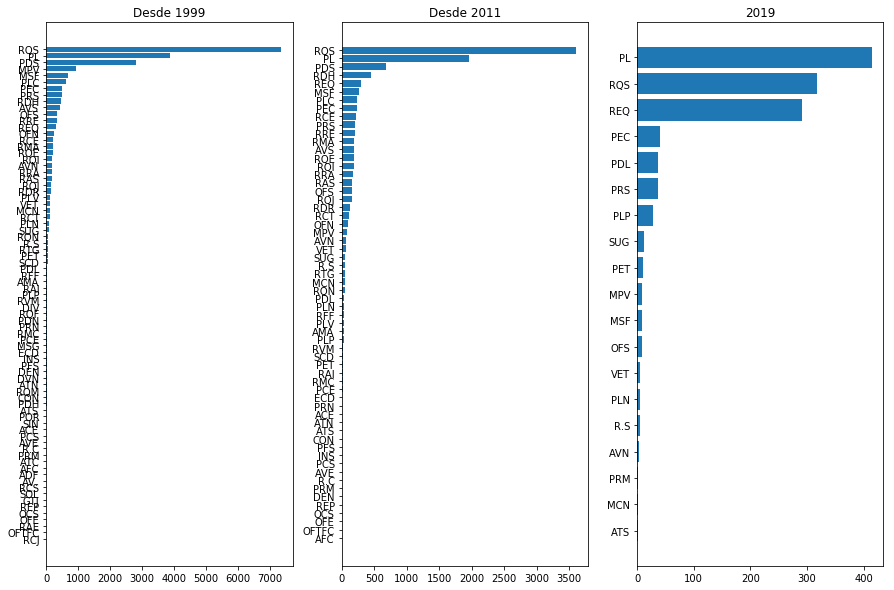

In [70]:
pl.figure(figsize=(15,10))

pl.subplot(1,3,1)
pl.title('Desde 1999')
nByTipo = s.loc[(s.ano>=1999)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.subplot(1,3,2)
pl.title('Desde 2011')
nByTipo = s.loc[(s.ano>=2011)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.subplot(1,3,3)
pl.title('2019')
nByTipo = s.loc[(s.ano>=2019)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.show()

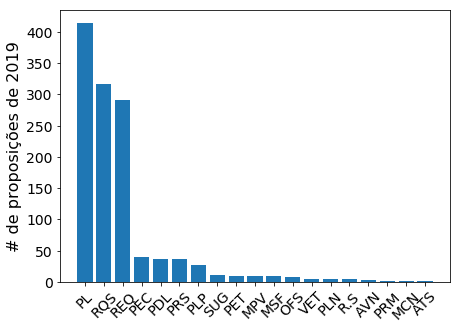

In [72]:
pl.figure(figsize=(7,5))
#pl.title('2019')
nByTipo = s.loc[(s.ano>=2019)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values(ascending=False)
x = np.arange(1,1+len(nByTipo))
pl.xticks(x,nByTipo.index.values, rotation=45)
pl.bar(x,nByTipo.values)
pl.gca().tick_params(labelsize=14)
pl.ylabel(u'# de proposições de 2019', fontsize=16)
#xu.saveFigWdate('graficos/proposicoes-2019-por-tipo.pdf')
pl.show()

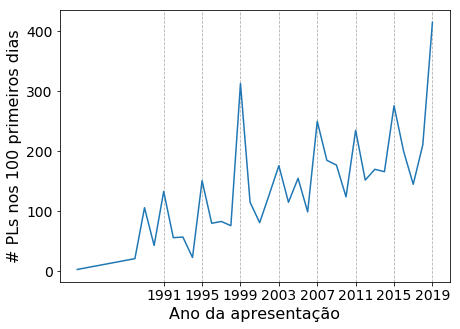

In [73]:
pl.figure(figsize=(7,5))
pl.plot(s.loc[s.siglaTipo=='PL'].groupby('ano')['id'].size())
pl.xticks(np.arange(2019,1990,-4))
pl.grid(axis='x', linestyle='--')
pl.gca().tick_params(labelsize=14)
pl.xlabel(u'Ano da apresentação', fontsize=16)
pl.ylabel(u'# PLs nos 100 primeiros dias', fontsize=16)
#xu.saveFigWdate('graficos/PLs-por-ano.pdf')
pl.show()

### Frequência dos temas para PLs

In [505]:
r.loc[(r.siglaTipo=='PL') & (r.tema == 'Sem tema')].groupby('ano').count()['numero']

ano
1980      1
1981      2
1982      3
1984      3
1985      3
1986      2
1987      3
1988    110
1989    417
1990    246
1991    414
1992    183
1993    162
1994     97
1995    331
1996    271
1997    294
1998    189
2019    197
Name: numero, dtype: int64

In [506]:
filters = (r.siglaTipo=='PL') & (r.tema != 'Sem tema')

In [507]:
# Calcula total de proposições em cada ano:
nPLTotalByAno      = r.loc[filters].groupby('ano').size()
nPLTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nPLByAnoTema      = r.loc[filters].groupby(['ano','tema']).size()
nPLByAnoTema.name = 'counts'
nPLByAnoTema      = nPLByAnoTema.reset_index()

# Junta as duas informações acima:
nPLByAnoTema = nPLByAnoTema.join(nPLTotalByAno, on='ano', how='outer')

In [508]:
# Calcula fração das proposições em cada tema, por ano:
nPLByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nPLByAnoTema.counts))
nPLByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nPLByAnoTema.ntotal))
nPLByAnoTema['frac']    = nPLByAnoTema.counts/nPLByAnoTema.ntotal
nPLByAnoTema['fracErr'] = np.sqrt(nPLByAnoTema.counts/nPLByAnoTema.ntotal**2 - \
                                  nPLByAnoTema.counts**2/nPLByAnoTema.ntotal**3)

In [509]:
listaTemasPL = np.array(sorted(r['tema'].unique()))

In [510]:
mFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFracPL.name = 'fracMean'
sFracPL.name = 'fracDev'
changeBasePL = nPLByAnoTema.loc[nPLByAnoTema.ano==2019].join(mFracPL,on='tema').join(sFracPL,on='tema')
changeBasePL['dfrac'] = changeBasePL['frac']-changeBasePL['fracMean']
changeBasePL = changeBasePL.sort_values('frac')

In [511]:
changeBasePL = changeBasePL.fillna(0)

In [512]:
fracColorPL = [fracColorF(x,m,s) for x,m,s in zip(changeBasePL['frac'],changeBasePL['fracMean'],changeBasePL['fracDev'])]

In [513]:
changeBasePL.sum()

ano                                                          74703
tema             TurismoDireitos políticos, nacionalidade e cid...
counts                                                         231
ntotal                                                        8547
poissonCounts                                              82.7723
poissonTotal                                               562.351
frac                                                             1
fracErr                                                   0.351058
fracMean                                                  0.968053
fracDev                                                   0.320193
dfrac                                                    0.0276178
dtype: object

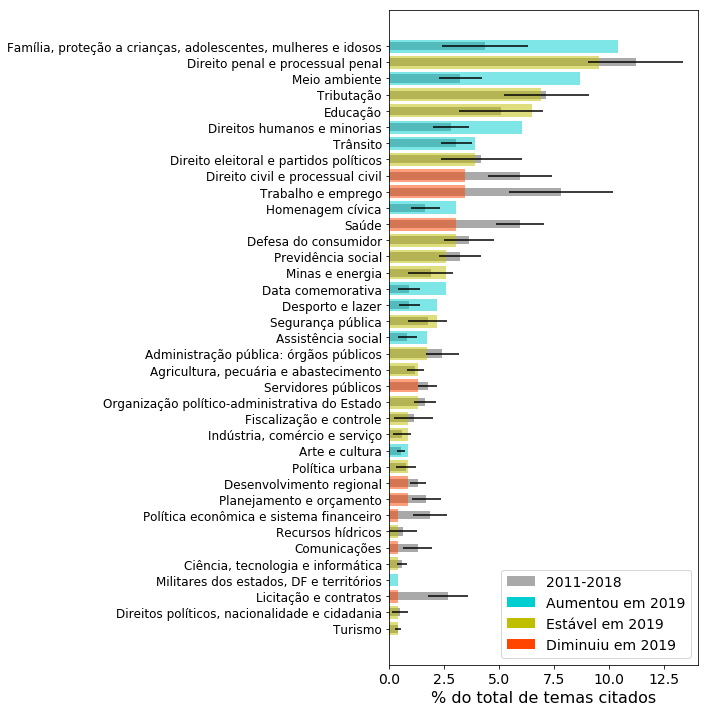

In [516]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBasePL.fracMean.values, xerr=100*changeBasePL.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pls-temas-senado-r-completo.pdf', bbox_inches='tight')
pl.show()

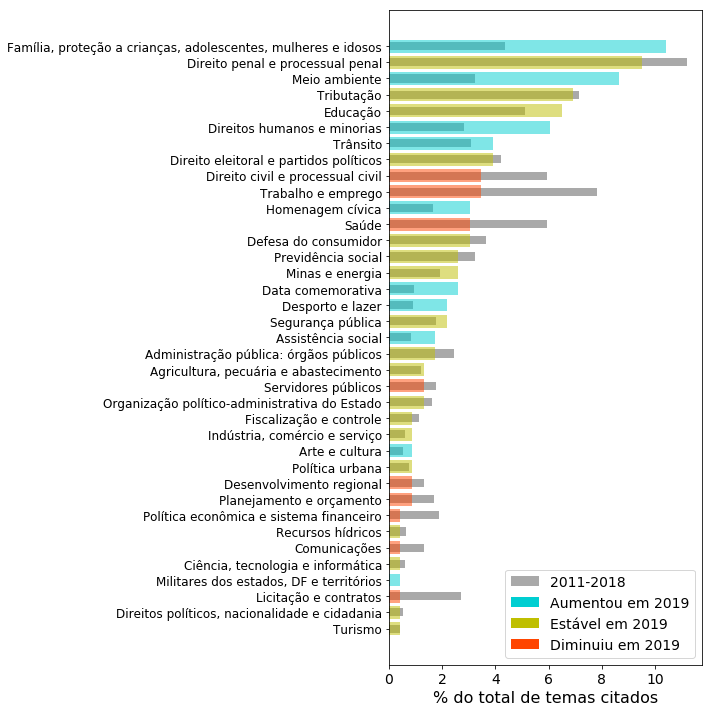

In [517]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBasePL.fracMean.values,  height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pls-temas-senado-r-semicompleto.pdf', bbox_inches='tight')
pl.show()

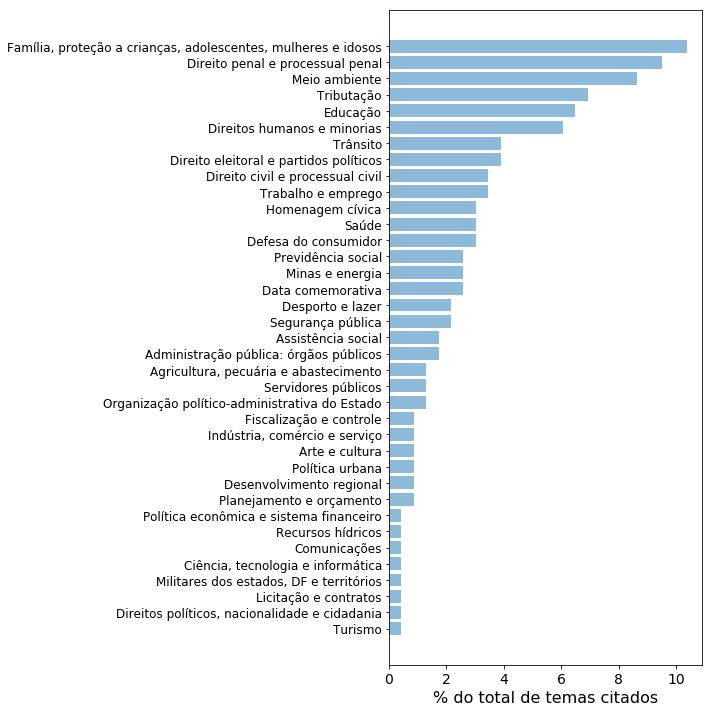

In [519]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
# pl.barh(x,100*changeBasePL.fracMean.values,  height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
# pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pls-temas-senado-r-simples.pdf', bbox_inches='tight')
pl.show()

In [486]:
filters = (r.siglaTipo=='PEC') & (r.tema != 'Sem tema')

In [487]:
# Calcula total de proposições em cada ano:
nPLTotalByAno      = r.loc[filters].groupby('ano').size()
nPLTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nPLByAnoTema      = r.loc[filters].groupby(['ano','tema']).size()
nPLByAnoTema.name = 'counts'
nPLByAnoTema      = nPLByAnoTema.reset_index()

# Junta as duas informações acima:
nPLByAnoTema = nPLByAnoTema.join(nPLTotalByAno, on='ano', how='outer')

In [488]:
# Calcula fração das proposições em cada tema, por ano:
nPLByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nPLByAnoTema.counts))
nPLByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nPLByAnoTema.ntotal))
nPLByAnoTema['frac']    = nPLByAnoTema.counts/nPLByAnoTema.ntotal
nPLByAnoTema['fracErr'] = np.sqrt(nPLByAnoTema.counts/nPLByAnoTema.ntotal**2 - \
                                  nPLByAnoTema.counts**2/nPLByAnoTema.ntotal**3)

In [489]:
listaTemasPL = np.array(sorted(r['tema'].unique()))

In [490]:
mFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFracPL.name = 'fracMean'
sFracPL.name = 'fracDev'
changeBasePL = nPLByAnoTema.loc[nPLByAnoTema.ano==2019].join(mFracPL,on='tema').join(sFracPL,on='tema')
changeBasePL['dfrac'] = changeBasePL['frac']-changeBasePL['fracMean']
changeBasePL = changeBasePL.sort_values('frac')

In [491]:
changeBasePL = changeBasePL.fillna(0)

In [492]:
fracColorPL = [fracColorF(x,m,s) for x,m,s in zip(changeBasePL['frac'],changeBasePL['fracMean'],changeBasePL['fracDev'])]

In [493]:
changeBasePL.sum()

ano                                                          26247
tema             Administração pública: órgãos públicosDefesa n...
counts                                                          23
ntotal                                                         299
poissonCounts                                              16.5605
poissonTotal                                               62.3458
frac                                                             1
fracErr                                                    0.68598
fracMean                                                  0.717015
fracDev                                                    0.36231
dfrac                                                     0.282985
dtype: object

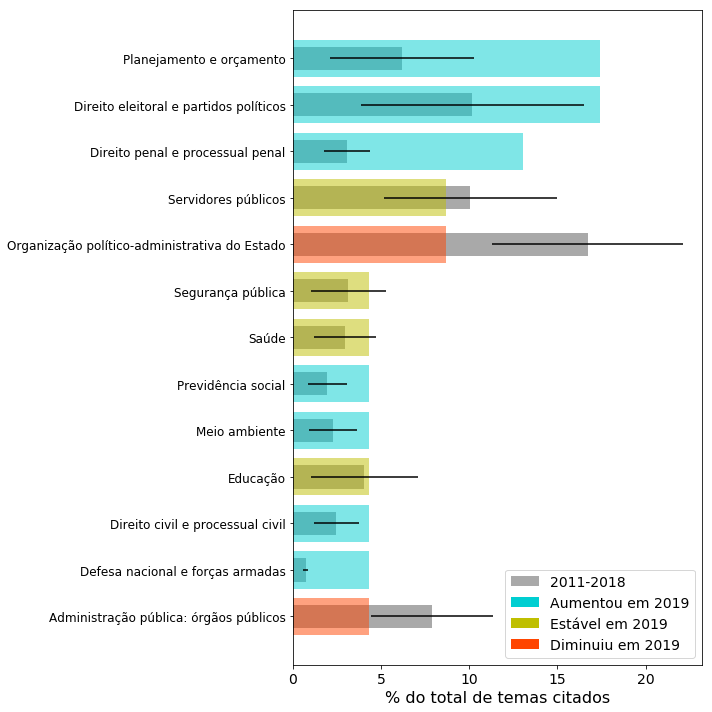

In [497]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBasePL.fracMean.values, xerr=100*changeBasePL.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pecs-temas-senado-r-completo.pdf', bbox_inches='tight')
pl.show()

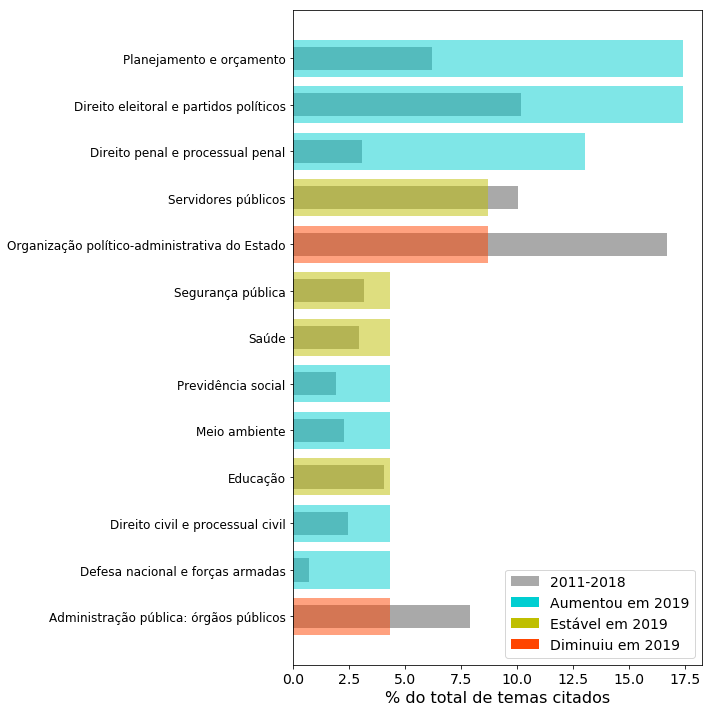

In [503]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBasePL.fracMean.values,  height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pecs-temas-senado-r-semicompleto.pdf', bbox_inches='tight')
pl.show()

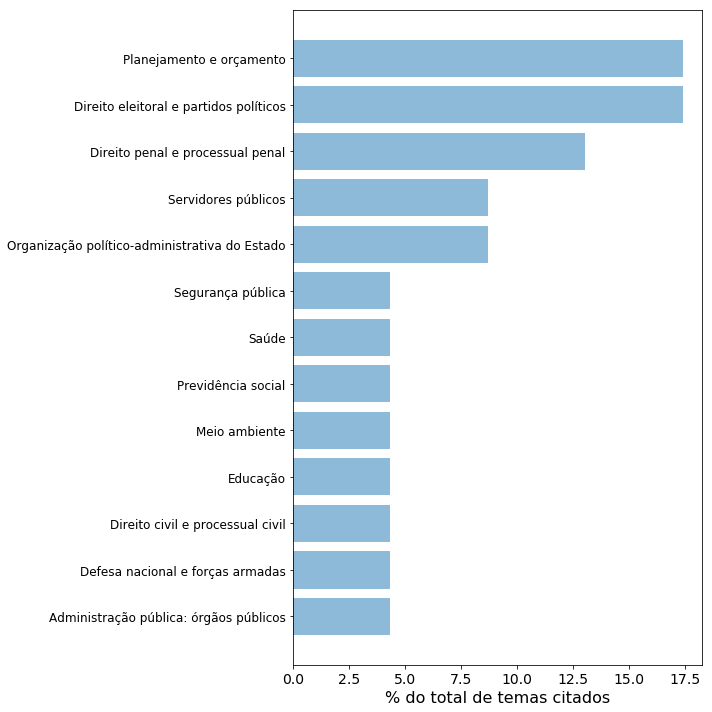

In [502]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
# pl.barh(x,100*changeBasePL.fracMean.values,  height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
# pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'pecs-temas-senado-r-simples.pdf', bbox_inches='tight')
pl.show()

AttributeError: 'DataFrame' object has no attribute 'tema'

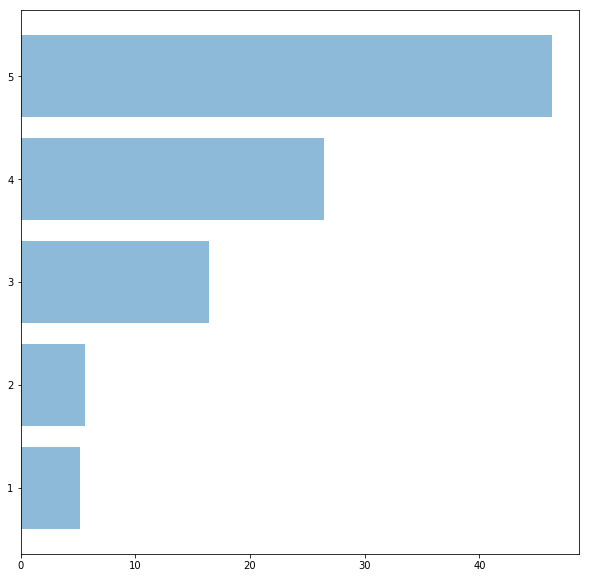

In [530]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
# pl.barh(x,100*changeBasePL.fracMean.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)


# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
# pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.tight_layout()
pl.savefig(OUTPUT_PATH / 'temas-senado-r-simples.pdf', bbox_inches='tight')
pl.show()

### Macro Tema

In [520]:
filters = (r.siglaTipo=='PL') & (r.tema != 'Sem tema')

In [521]:
# Calcula total de proposições em cada ano:
nPLTotalByAno      = r.loc[filters].groupby('ano').size()
nPLTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nPLByAnoTema      = r.loc[filters].groupby(['ano','macro_tema']).size()
nPLByAnoTema.name = 'counts'
nPLByAnoTema      = nPLByAnoTema.reset_index()

# Junta as duas informações acima:
nPLByAnoTema = nPLByAnoTema.join(nPLTotalByAno, on='ano', how='outer')

In [522]:
# Calcula fração das proposições em cada tema, por ano:
nPLByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nPLByAnoTema.counts))
nPLByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nPLByAnoTema.ntotal))
nPLByAnoTema['frac']    = nPLByAnoTema.counts/nPLByAnoTema.ntotal
nPLByAnoTema['fracErr'] = np.sqrt(nPLByAnoTema.counts/nPLByAnoTema.ntotal**2 - \
                                  nPLByAnoTema.counts**2/nPLByAnoTema.ntotal**3)

In [523]:
listaTemasPL = np.array(sorted(r['macro_tema'].unique()))

In [524]:
mFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('macro_tema')['frac'].mean()
sFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('macro_tema')['frac'].std()
mFracPL.name = 'fracMean'
sFracPL.name = 'fracDev'
changeBasePL = nPLByAnoTema.loc[nPLByAnoTema.ano==2019].join(mFracPL,on='macro_tema').join(sFracPL,on='macro_tema')
changeBasePL['dfrac'] = changeBasePL['frac']-changeBasePL['fracMean']
changeBasePL = changeBasePL.sort_values('frac')

In [525]:
fracColorPL = [fracColorF(x,m,s) for x,m,s in zip(changeBasePL['frac'],changeBasePL['fracMean'],changeBasePL['fracDev'])]

In [526]:
changeBasePL.sum()

ano                                                        10095
macro_tema       AdministrativoHonoríficoEconômicoJurídicoSocial
counts                                                       231
ntotal                                                      1155
poissonCounts                                            31.3884
poissonTotal                                             75.9934
frac                                                           1
fracErr                                                  0.11597
fracMean                                                       1
fracDev                                                 0.106719
dfrac                                                5.55112e-17
dtype: object

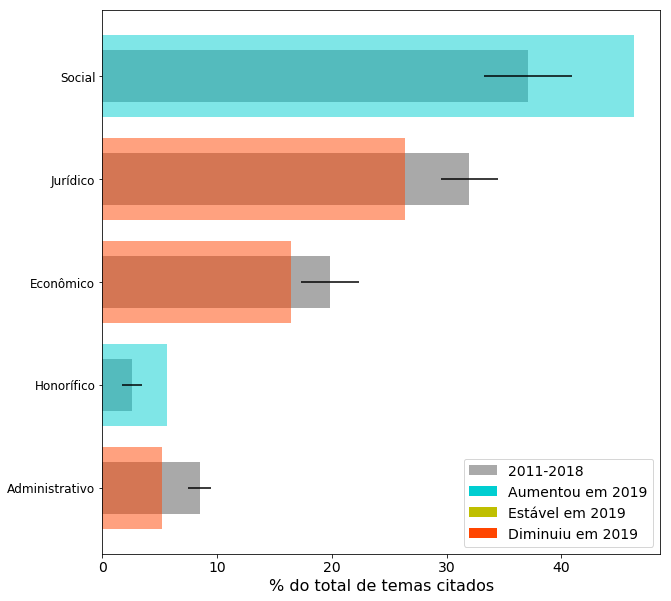

In [529]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBasePL.fracMean.values, xerr=100*changeBasePL.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.macro_tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.savefig(OUTPUT_PATH / 'pls-macro-temas-senado-r-completo.pdf', bbox='tight')
pl.show()

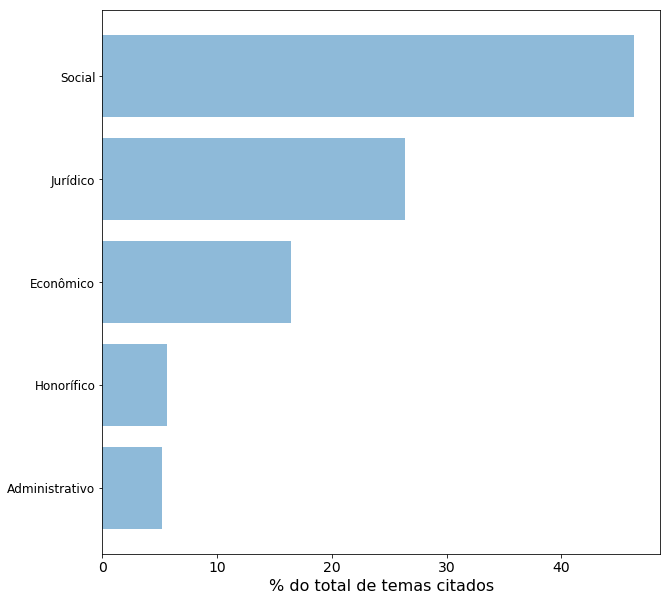

In [528]:
from matplotlib.patches import Patch
import matplotlib.colors as colors

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

#pl.subplot(1,2,1)
# pl.barh(x,100*changeBasePL.fracMean.values, xerr=100*changeBasePL.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, alpha=0.5)
pl.yticks(x,changeBasePL.macro_tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
# pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


# pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.savefig(OUTPUT_PATH / 'pls-macro-temas-senado-r-simples.pdf', bbox='tight')
pl.show()

## Frequência de temas para recortes não usados

#### Para a seleção feita (dataframe 's')

In [454]:
filters = (s.tema != 'Sem tema')

In [455]:
# Calcula total de proposições em cada ano:
nSTotalByAno      = s.loc[filters].groupby('ano').size()
nSTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nSByAnoTema      = s.loc[filters].groupby(['ano','tema']).size()
nSByAnoTema.name = 'counts'
nSByAnoTema      = nSByAnoTema.reset_index()

# Junta as duas informações acima:
nSByAnoTema = nSByAnoTema.join(nSTotalByAno, on='ano', how='outer')

In [456]:
# Calcula fração das proposições em cada tema, por ano:
nSByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nSByAnoTema.counts))
nSByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nSByAnoTema.ntotal))
nSByAnoTema['frac']    = nSByAnoTema.counts/nSByAnoTema.ntotal
nSByAnoTema['fracErr'] = np.sqrt(nSByAnoTema.counts/nSByAnoTema.ntotal**2 - nSByAnoTema.counts**2/nSByAnoTema.ntotal**3)

In [457]:
listaTemasS = np.array(sorted(s.tema.unique()))

In [458]:
mFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFracS.name = 'fracMean'
sFracS.name = 'fracDev'
changeBaseS = nSByAnoTema.loc[nSByAnoTema.ano==2019].join(mFracS,on='tema').join(sFracS,on='tema')
changeBaseS['dfrac'] = changeBaseS['frac']-changeBaseS['fracMean']
changeBaseS = changeBaseS.sort_values('frac')

In [459]:
# changeBaseS = changeBaseS.fillna(0)

In [460]:
fracColorS = [fracColorF(x,m,s) for x,m,s in zip(changeBaseS['frac'],changeBaseS['fracMean'],changeBaseS['fracDev'])]

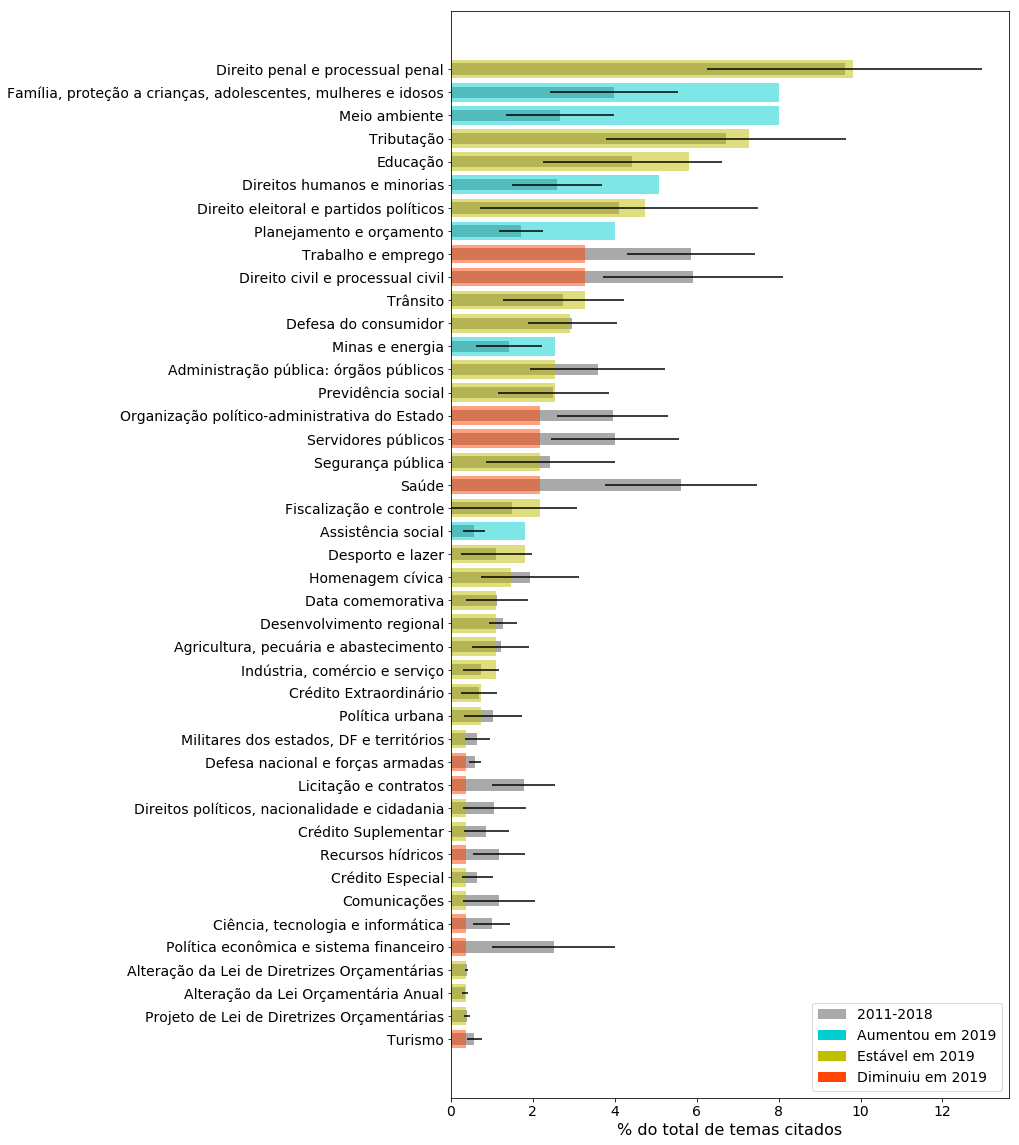

In [463]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,20))
x = np.arange(1,1+len(changeBaseS))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBaseS.fracMean.values, xerr=100*changeBaseS.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBaseS.frac.values, color=fracColorS, alpha=0.5)
pl.yticks(x,changeBaseS.tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim(0)
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.savefig(OUTPUT_PATH / 'temas-senado-s-completo.pdf', bbox='tight')
pl.show()

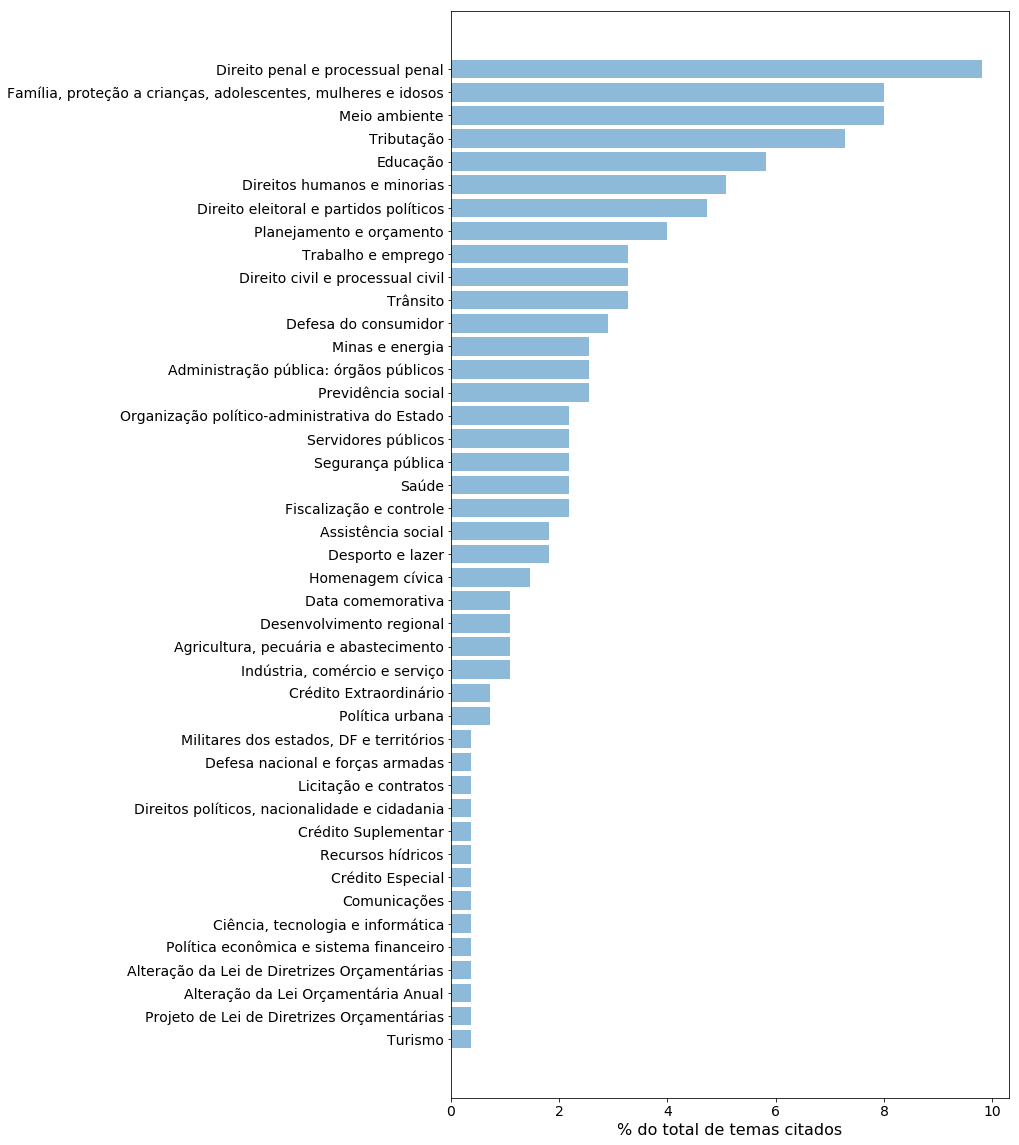

In [464]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,20))
x = np.arange(1,1+len(changeBaseS))

#pl.subplot(1,2,1)
# pl.barh(x,100*changeBaseS.fracMean.values, xerr=100*changeBaseS.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBaseS.frac.values,  alpha=0.5)
pl.yticks(x,changeBaseS.tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
# pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim(0)
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.savefig(OUTPUT_PATH / 'temas-senado-s-simples.pdf', bbox='tight')
pl.show()

In [479]:
# Calcula total de proposições em cada ano:
nSTotalByAno      = s.loc[filters].groupby('ano').size()
nSTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nSByAnoTema      = s.loc[filters].groupby(['ano','macro_tema']).size()
nSByAnoTema.name = 'counts'
nSByAnoTema      = nSByAnoTema.reset_index()

# Junta as duas informações acima:
nSByAnoTema = nSByAnoTema.join(nSTotalByAno, on='ano', how='outer')

In [480]:
# Calcula fração das proposições em cada tema, por ano:
nSByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nSByAnoTema.counts))
nSByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nSByAnoTema.ntotal))
nSByAnoTema['frac']    = nSByAnoTema.counts/nSByAnoTema.ntotal
nSByAnoTema['fracErr'] = np.sqrt(nSByAnoTema.counts/nSByAnoTema.ntotal**2 - nSByAnoTema.counts**2/nSByAnoTema.ntotal**3)

In [481]:
s['macro_tema'] = s.fillna('Sem macrotema')

In [482]:
listaTemasS = np.array(sorted(s.tema.unique()))

In [483]:
mFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('macro_tema')['frac'].mean()
sFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('macro_tema')['frac'].std()
mFracS.name = 'fracMean'
sFracS.name = 'fracDev'
changeBaseS = nSByAnoTema.loc[nSByAnoTema.ano==2019].join(mFracS,on='macro_tema').join(sFracS,on='macro_tema')
changeBaseS['dfrac'] = changeBaseS['frac']-changeBaseS['fracMean']
changeBaseS = changeBaseS.sort_values('frac')

In [484]:
fracColorS = [fracColorF(x,m,s) for x,m,s in zip(changeBaseS['frac'],changeBaseS['fracMean'],changeBaseS['fracDev'])]

ValueError: Invalid RGBA argument: None

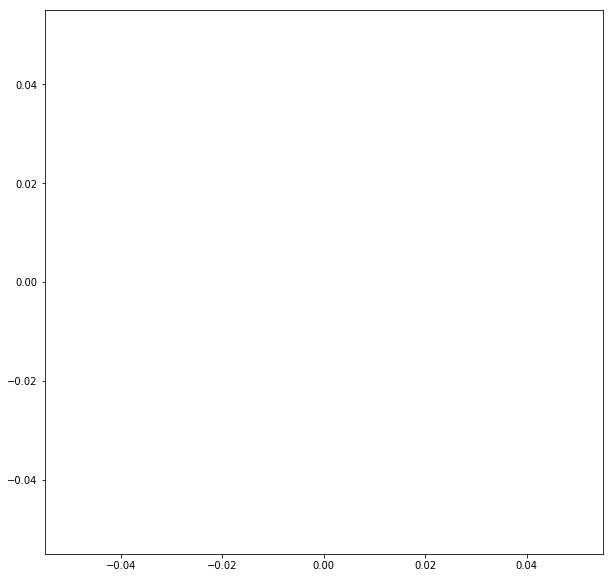

In [485]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBaseS))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBaseS.fracMean.values, xerr=100*changeBaseS.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBaseS.frac.values, color=fracColorS, alpha=0.5)
pl.yticks(x,changeBaseS.macro_tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim(0)
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.savefig(OUTPUT_PATH / 'macro-temas-senado-s-completo.pdf', bbox='tight')
pl.show()

#### Para a base completa

##### Preparo de base de dados de contagem

In [112]:
# Calcula total de proposições em cada ano:
nTotalByAno      = r.groupby('ano').size()
nTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nByAnoTema      = r.groupby(['ano','tema']).size()
nByAnoTema.name = 'counts'
nByAnoTema      = nByAnoTema.reset_index()

# Junta as duas informações acima:
nByAnoTema = nByAnoTema.join(nTotalByAno, on='ano', how='outer')

In [115]:
check_missing(nByAnoTema)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [116]:
# Calcula fração das proposições em cada tema, por ano:
nByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nByAnoTema.counts))
nByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nByAnoTema.ntotal))
nByAnoTema['frac']    = nByAnoTema.counts/nByAnoTema.ntotal
nByAnoTema['fracErr'] = np.sqrt(nByAnoTema.counts/nByAnoTema.ntotal**2 - nByAnoTema.counts**2/nByAnoTema.ntotal**3)

In [117]:
listaTemas = np.array(sorted(r.tema.unique()))

In [118]:
# SÉRIES INTERESSANTES:
# i=1, agricultura, salto em 2011;
# i=3, cidades e desenvolvimento urbano, crescimento a partir de 2005, 2019 bem baixo.
# i=5, comunicações, pico de 2002 a 2010, queda em 2019.
# i=6, defesa e segurança, crescimento lento e constate, com pico em 2019.
# i=7, direito civil, queda de 1997 a 2007, depois estável até 2015, ligeiro aumento, 2019 estável, pouco interessante.
# i=8, direito constituicional, pico em 2018 e 2019.
# i=9, direito penal, U de 2001 a 2018, pico bem alto em 2019.
# i=10, direito do consumidor, surto em 2011 e crescimento desde então.
# i=11, direito e justiça, surto em 2011 e crescimento desde então (mas menos que acima).
# i=12, direitos humanos e minorias, crescimento a partir de 2011, com pico em 2019.
# i=15, recursos hídricos e minerais, leve crescimento desde 2003.
# i=17, estrutura fundiária, queda em 2011, podemos relacionar com agricultura.
# i=18, finanças públicas e orçamento, U de 1999 a 2002, platô posterior, pouco interessante.
# i=19, homenagens e datas comemorativas, crescimento constante desde 2002.
# i=21, meio ambiente e desenv. sust., pico em 2019.
# i=22, políticos, partidos e eleições, platô desde 2011.
# i=25, relações internacionais, crescimento de 2001 a 2006, estável até 2018, queda abrupta em 2019.
# i=26, saúde, crescimento desde 1987, queda em 2019.
# i=27, trabalho e empredo, queda de 1987 a 2003, estável desde então, ligeiro aumento em 2019.


##### Média e desvio padrão de 2011 a 2018

In [119]:
mFrac = nByAnoTema.loc[(nByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFrac = nByAnoTema.loc[(nByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFrac.name = 'fracMean'
sFrac.name = 'fracDev'
changeBase = nByAnoTema.loc[nByAnoTema.ano==2019].join(mFrac,on='tema').join(sFrac,on='tema')
changeBase['dfrac'] = changeBase['frac']-changeBase['fracMean']
changeBase = changeBase.sort_values('frac')

In [120]:
fracColor = [fracColorF(x,m,s) for x,m,s in zip(changeBase['frac'],changeBase['fracMean'],changeBase['fracDev'])]

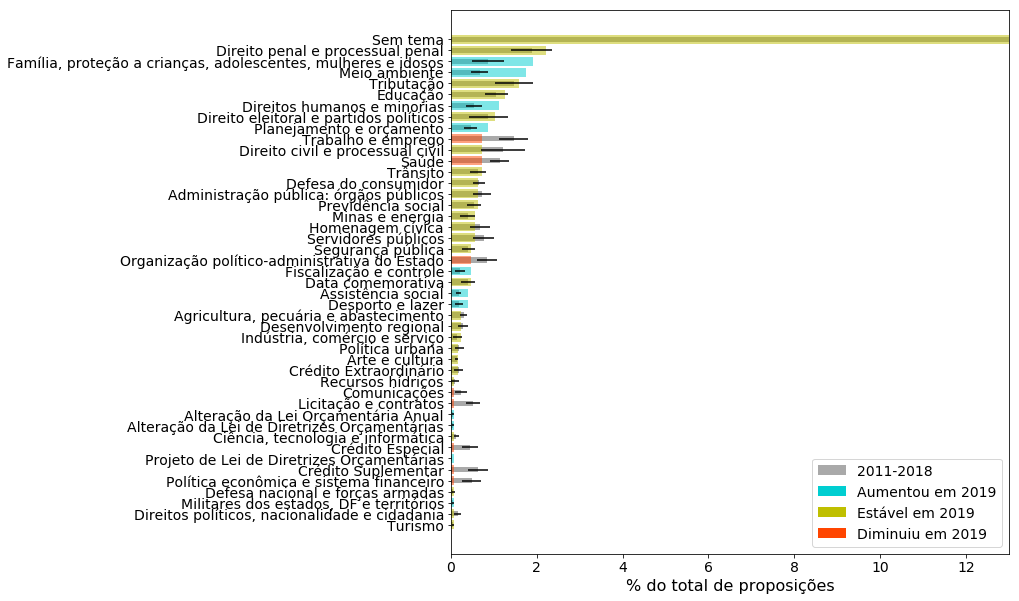

In [121]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBase))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBase.fracMean.values, xerr=100*changeBase.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBase.frac.values, color=fracColor, alpha=0.5)
pl.yticks(x,changeBase.tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim([0,13])
pl.xlabel(u'% do total de proposições', fontsize=16)
#xu.saveFigWdate('graficos/temas_proposicoes_fracao2019-vs-mediaAnterior.pdf')
pl.show()

## Gráficos de tendências históricas

#### Definição de funções

In [123]:
# Plotting function:
def trendPlot(x,y,yerr,coefs,cov,title):
    anoStart = 1999
    anoEnd   = 2019

    if len(coefs)==3:
        ypred = coefs[0]*x**2 + coefs[1]*x + coefs[2]
    elif len(coefs)==2:
        ypred = coefs[0]*x+coefs[1]
    elif len(coefs)==1:
        ypred = coefs[0]*np.ones(len(x))
    else:
        print('ERROR! Requested polynomial degree not implemented.')
        return 0
    
    from matplotlib import gridspec
    pl.figure(figsize=(7.4,5.5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # Plot full:
    pl.subplot(gs[0])
    # Título:
    pl.title(title, fontsize=16)
    # Texto:
    if len(coefs)==3:
        pl.text(0.95,0.95, 
                'Coef: {:.2e} +/- {:.2e}\n          {:.2e} +/- {:.2e}\n'.format(coefs[0],np.sqrt(cov[0][0]),
                                                                                 coefs[1],np.sqrt(cov[1][1])),
                transform = pl.gca().transAxes, fontsize=14, horizontalalignment='right', #backgroundcolor='white',
                verticalalignment='top')
    elif len(coefs)==2:
        pl.text(0.9,0.95, 'Coef: {:.2e} +/- {:.2e}'.format(coefs[0],np.sqrt(cov[0][0])),
                transform = pl.gca().transAxes, fontsize=14, horizontalalignment='right', #backgroundcolor='white',
                verticalalignment='top')
    # Plot mesmo:
    pl.errorbar(x, y, yerr=yerr, fmt='r-', label=u'Observado')
    pl.plot(x, ypred, 'b-', label=u'Ajuste até 2018')
    # Formatação:
    pl.xticks(np.arange(1987,2020,4))
    pl.grid(axis='x')
    # Eixo:
    pl.ylabel(u'% dos PLs', fontsize=16)
    pl.gca().tick_params(labelbottom=False)
    pl.xlim([anoStart-1,anoEnd+1])
    pl.gca().tick_params(labelsize=14)
    # Legenda:
    pl.legend(loc='upper left', fontsize=14)

    # Plot resíduos:
    pl.subplot(gs[1])
    pl.errorbar(x, (y-ypred), yerr=yerr, fmt='r-')
    pl.axhline(0,color='blue')
    # Formatação
    pl.xticks(np.arange(1987,2020,4))
    pl.grid(axis='x')
    pl.gca().tick_params(labelsize=14)
    # Eixo:
    pl.ylabel(u'Resíduos', fontsize=16)
    pl.xlabel('Ano', fontsize=16)
    pl.xlim([anoStart-1,anoEnd+1])

    pl.subplots_adjust(hspace=0.05)

In [153]:
i = 4

In [154]:
nPLByAnoTema.loc[(nPLByAnoTema.ano>=1999) & (nPLByAnoTema.tema==listaTemasPL[i])]['ano'].values

array([], dtype=int64)

In [165]:
# Ajuste linear:
def fitPoly(i, degree):
    baseTema = nPLByAnoTema
    anoStart = 1999
    anoEnd   = 2019
    x    =     baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['ano'].values
    y    = 100*baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['frac'].values
    yerr = 100*baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['fracErr'].values

    coefs, cov = np.polyfit(x[:-1],y[:-1],degree,w=1.0/yerr[:-1], cov=True)
    if degree==2:
        ypred = coefs[0]*x**2 + coefs[1]*x + coefs[2]
    elif degree==1:
        ypred = coefs[0]*x+coefs[1]
    elif degree==0:
        ypred = coefs[0]*np.ones(len(x))
    else:
        print('ERROR! Requested polynomial degree not implemented.')
        return 0
    return x,y,yerr,coefs,cov,ypred


def fitNplot(i, degree):
    x,y,yerr,coefs,cov,ypred = fitPoly(i, degree)
    trendPlot(x,y,yerr,coefs,cov,listaTemasPL[i])

In [166]:
import scipy as sc
def Ftest(i, d2, d1):
    """ Output p-value for F given by dof d2+1 and d1+1 (d1 and d2 are polynomial degree) and data from ith tema """
    result1 = fitPoly(i, d1)
    result2 = fitPoly(i, d2)
    rss1    = np.sum((result1[1][:-1]-result1[5][:-1])**2/result1[2][:-1]**2)
    rss2    = np.sum((result2[1][:-1]-result2[5][:-1])**2/result2[2][:-1]**2)
    n       = len(result1[0][:-1])
    F = (rss1-rss2)/(d2-d1)/(rss2/(n-d2-1))
    return 1.0 - sc.stats.f.cdf(F,d2+1,d1+1)

def defDegree(i):
    alphaVal = 0.05
    if Ftest(i,2,1)<alphaVal:
        return 2
    if Ftest(i,1,0)<alphaVal:
        return 1
    else:
        return 0

#### Gráficos interessantes

In [157]:
i = 1
print(Ftest(i,2,1), Ftest(i,1,0))

[1999 2000 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]
[1999 2000 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]
[1999 2000 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]
[1999 2000 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]
0.4321744005614445 0.34059353637629997


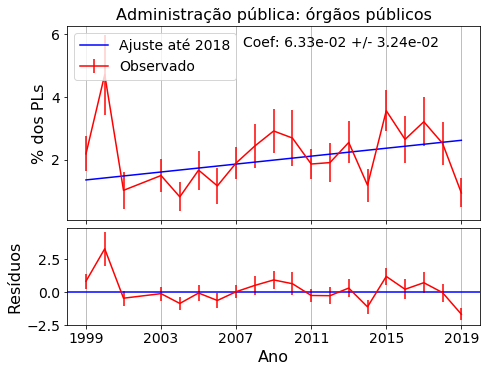

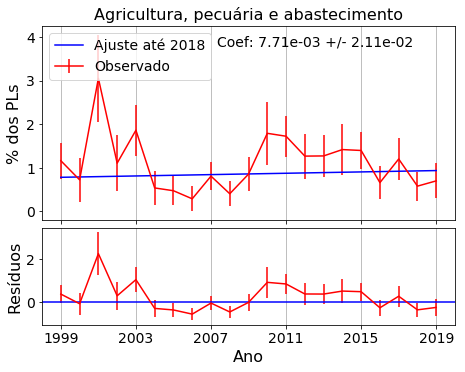

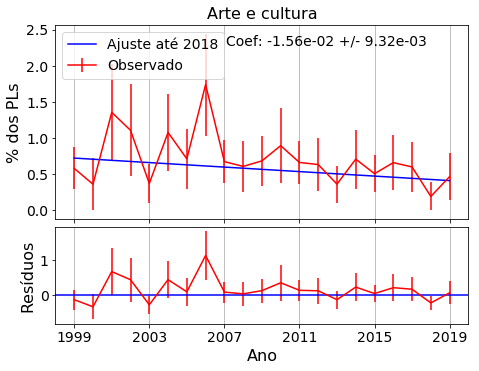

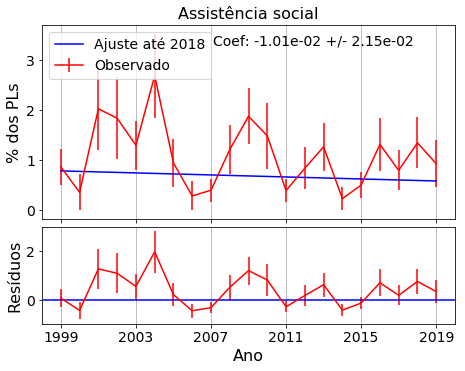

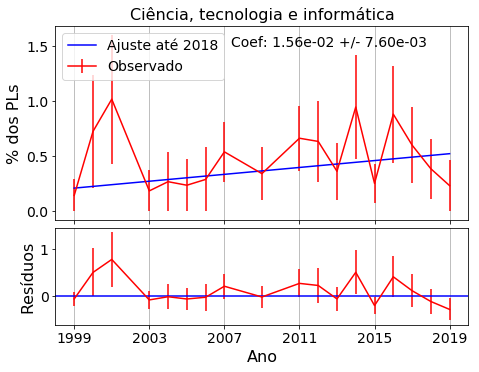

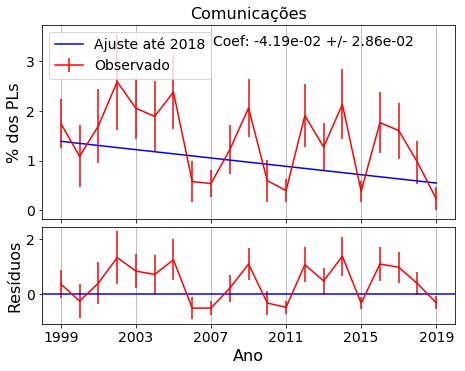

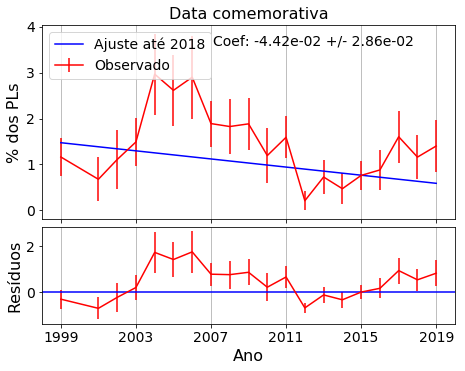

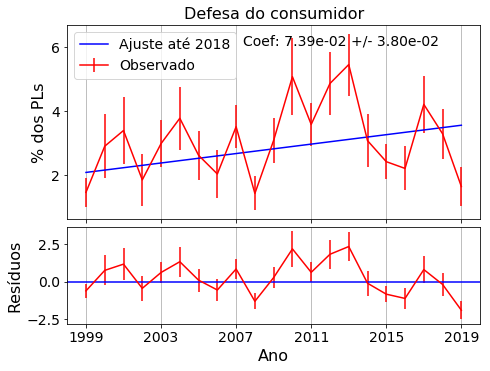

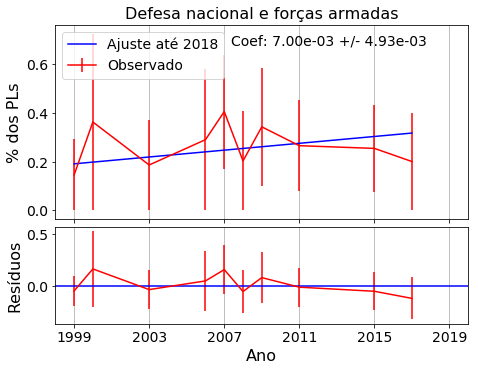

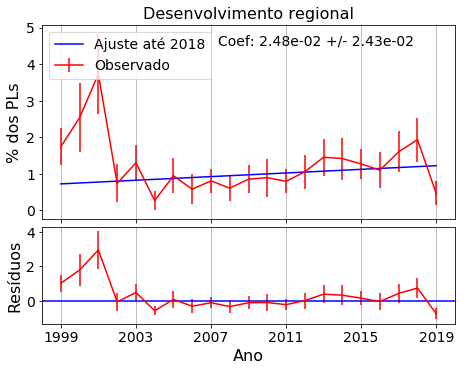

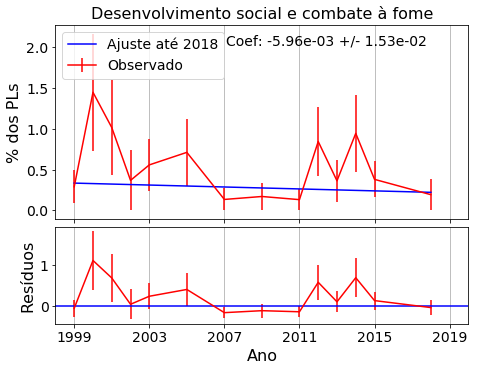

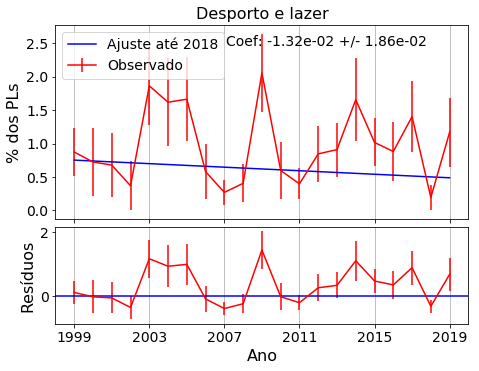

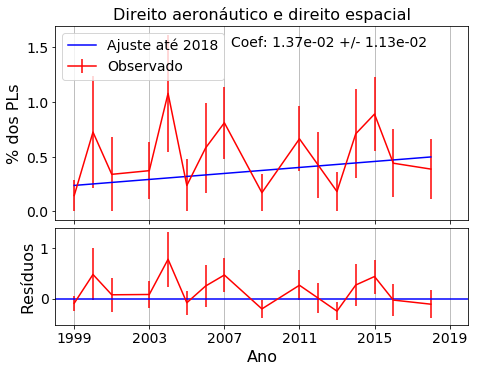

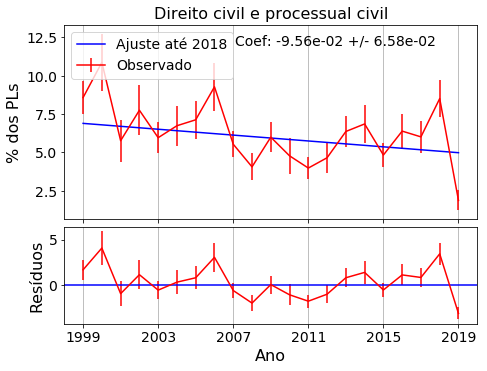

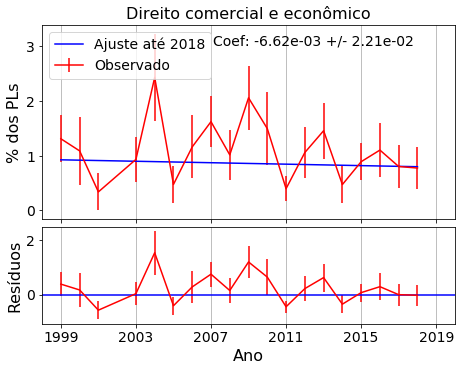

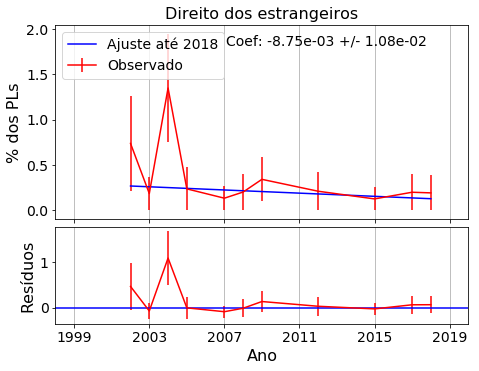

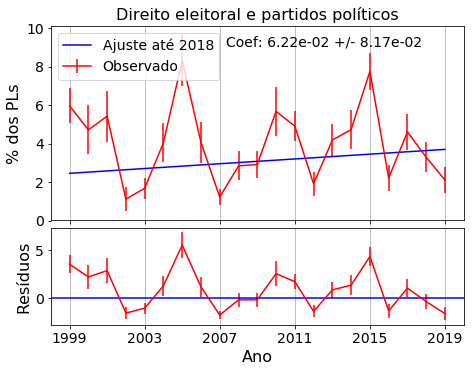

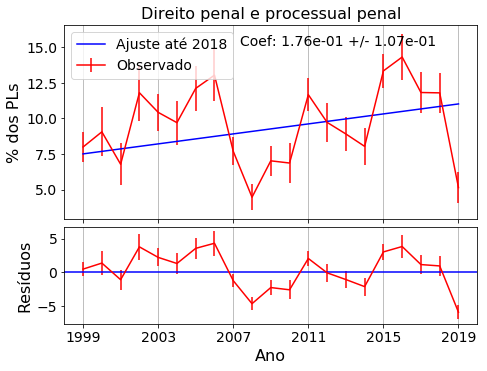

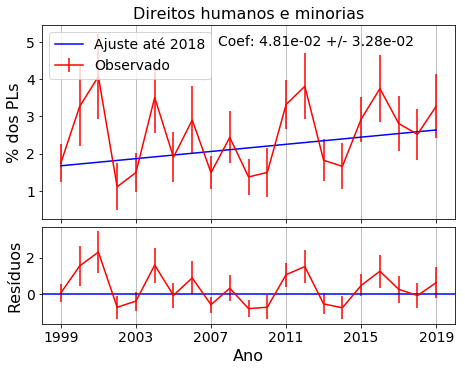

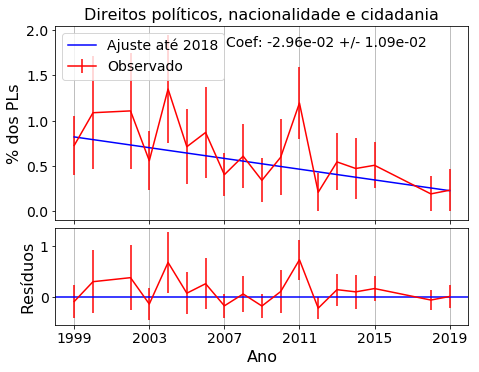

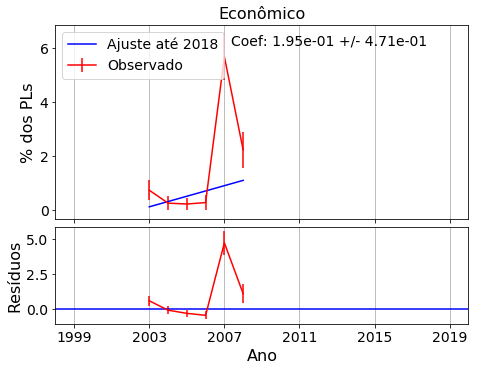

In [167]:
for i in range(1, 30):
    try:
        fitNplot(i,1)
    except:
        pass

[1999 2000 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]


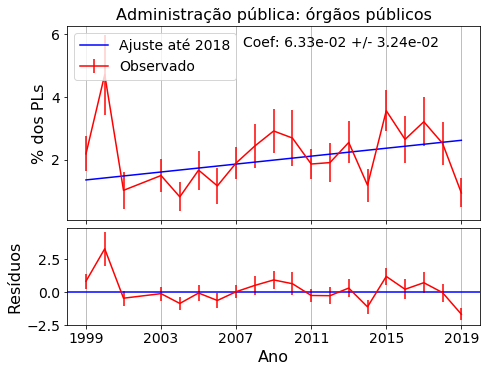

In [158]:
fitNplot(1,1)

[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]


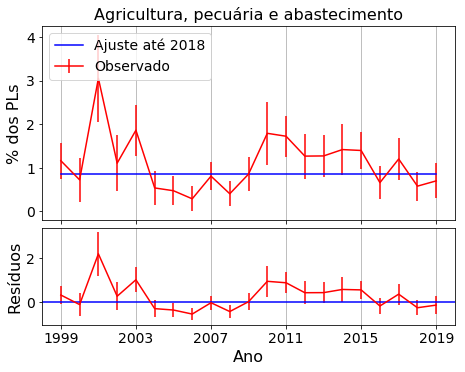

In [159]:
fitNplot(2,0)

[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]
[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]


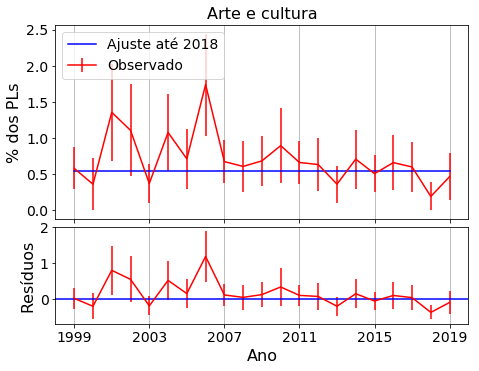

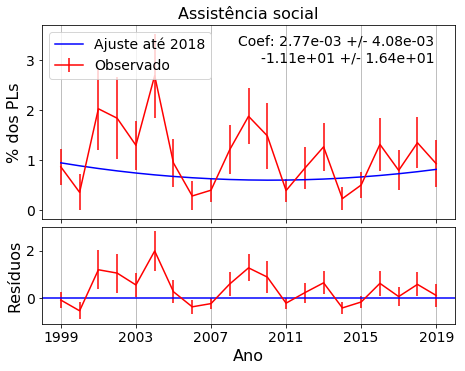

In [162]:
fitNplot(6,0)
fitNplot(7,2)

[1999 2000 2001 2003 2004 2005 2006 2007 2009 2011 2012 2013 2014 2015
 2016 2017 2018 2019]


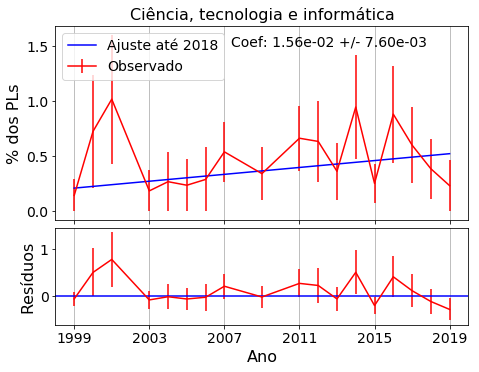

In [163]:
fitNplot(8,1)
#xu.saveFigWdate('graficos/PL-direitos-humanos-por-ano.pdf')

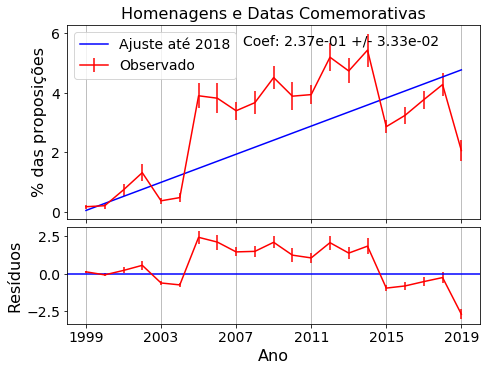

In [149]:
fitNplot(19,1)

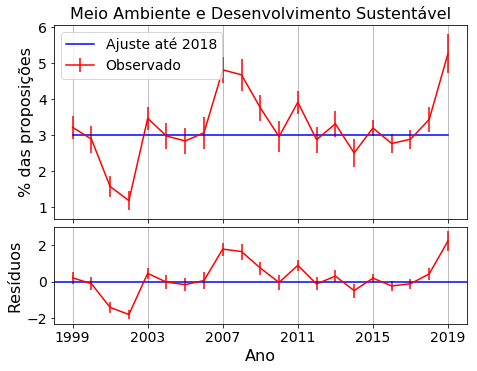

In [150]:
fitNplot(21,0)

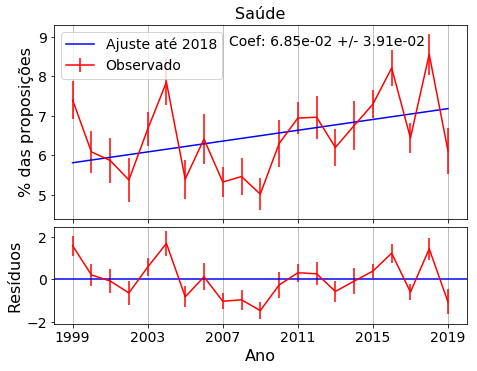

In [151]:
fitNplot(26,1)

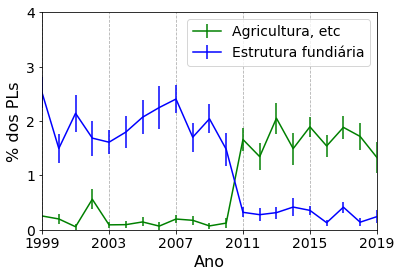

In [174]:
# Plot:
baseTema  = nPLByAnoTema
nByAno = baseTema.loc[baseTema.tema==listaTemasPL[1]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='g-', 
            label='Agricultura, etc')
nByAno = baseTema.loc[baseTema.tema==listaTemasPL[17]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='b-', 
            label=u'Estrutura fundiária')
#nByAno = nByAnoTema.loc[nByAnoTema.tema==listaTemas[17]]
#pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='b-', 
#            label=u'Estrutura fundiária')
# Formatação
pl.xticks(np.arange(1987,2020,4))
pl.grid(axis='x',linestyle='--')
pl.xlabel('Ano', fontsize=16)
pl.ylabel(u'% dos PLs', fontsize=16)
pl.ylim([0,4])
pl.xlim([1999,2019])
# Legenda:
pl.legend(loc='upper right', fontsize=14)
pl.gca().tick_params(labelsize=14)
#xu.saveFigWdate('graficos/PL-agricultura-por-ano.pdf')
pl.show()

#### Gráficos não tão interessantes

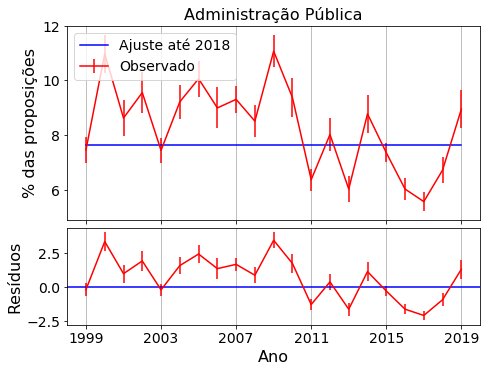

In [153]:
fitNplot(0,0)

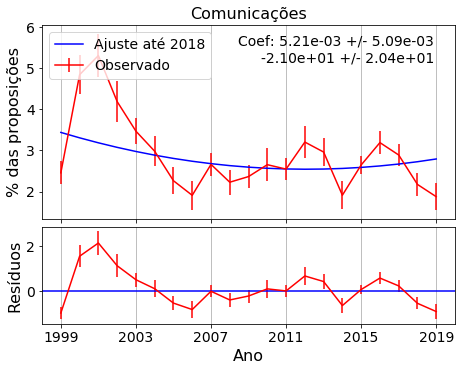

In [154]:
fitNplot(5,2)

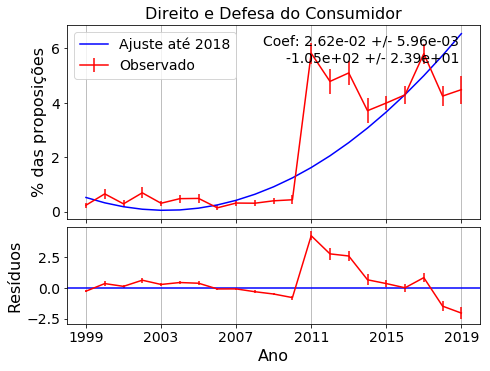

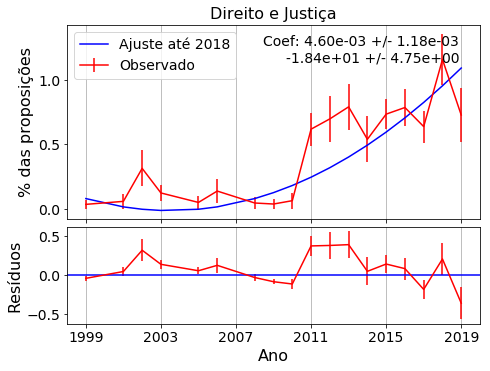

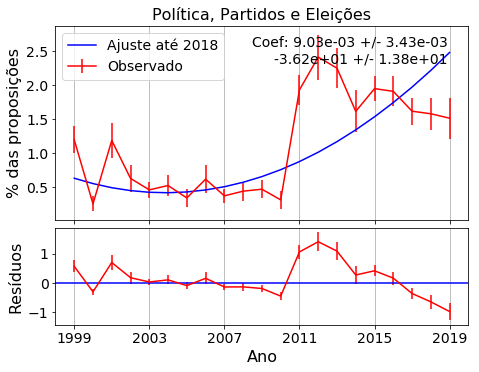

In [155]:
fitNplot(10,2)
fitNplot(11,2)
fitNplot(22,2)

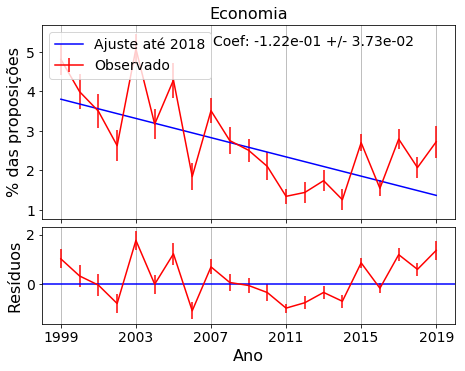

In [156]:
fitNplot(13,1)

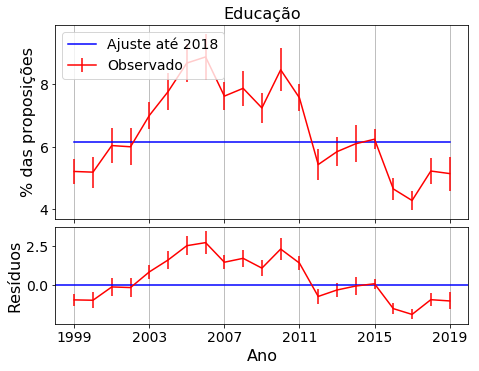

In [157]:
fitNplot(14,0)

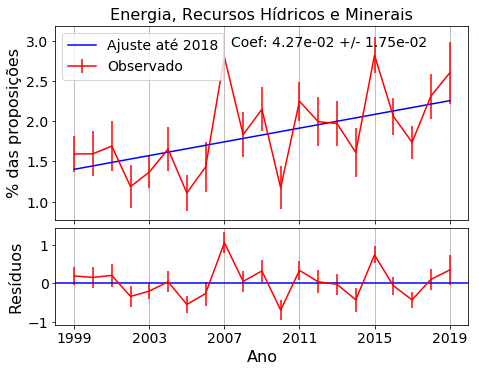

In [158]:
fitNplot(15,1)

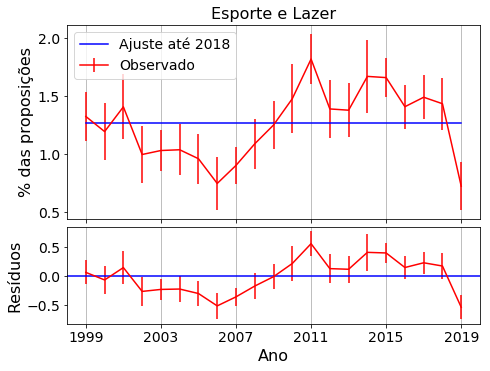

In [159]:
fitNplot(16,0)

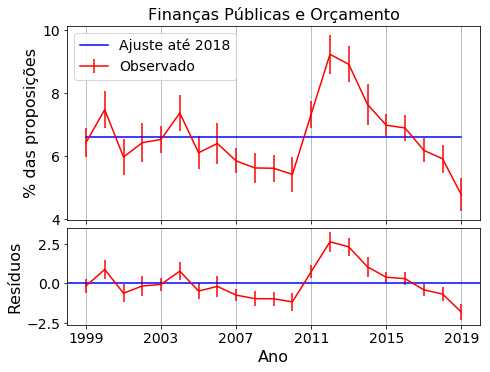

In [160]:
fitNplot(18,0)

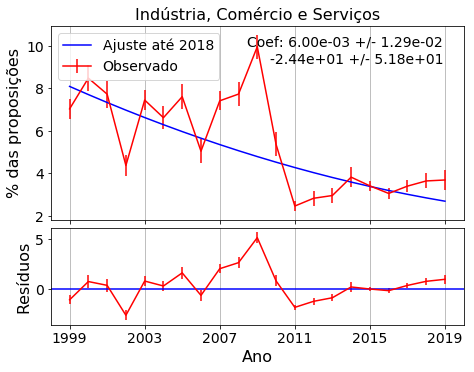

In [161]:
fitNplot(20,2)

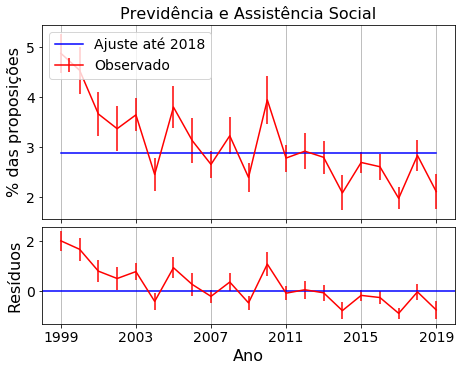

In [162]:
fitNplot(23,0)

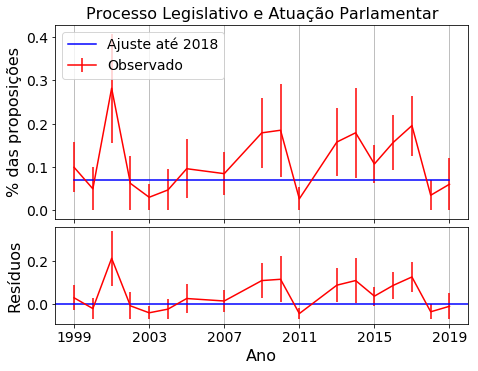

In [163]:
fitNplot(24,0)

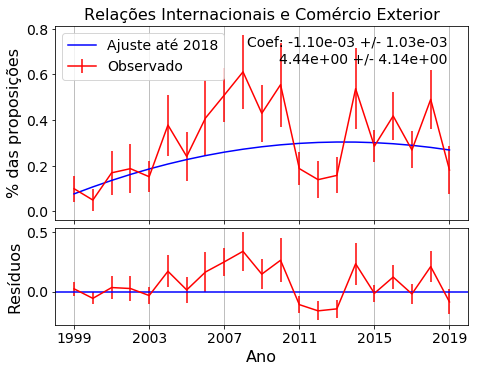

In [164]:
fitNplot(25,2)

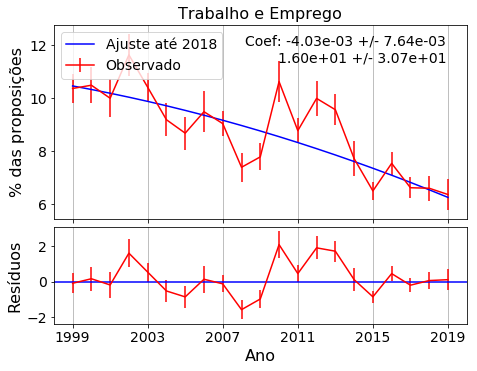

In [165]:
fitNplot(27,2)

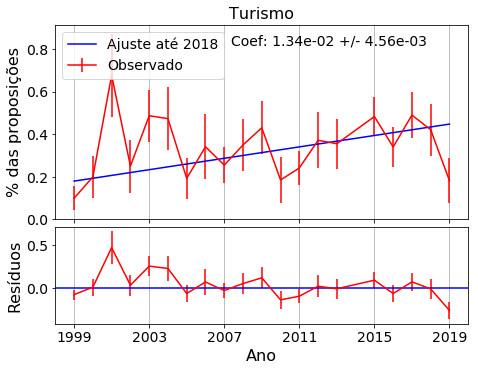

In [166]:
fitNplot(28,1)

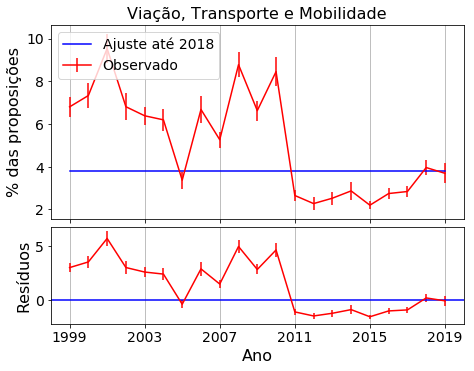

In [167]:
fitNplot(29,0)

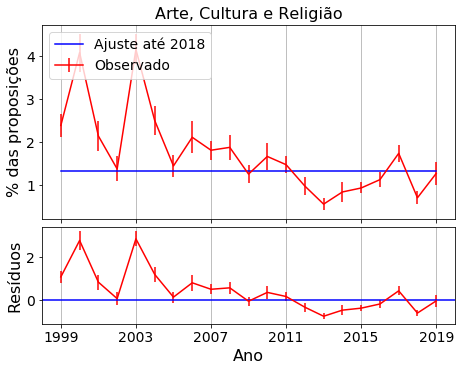

In [168]:
fitNplot(2,0)

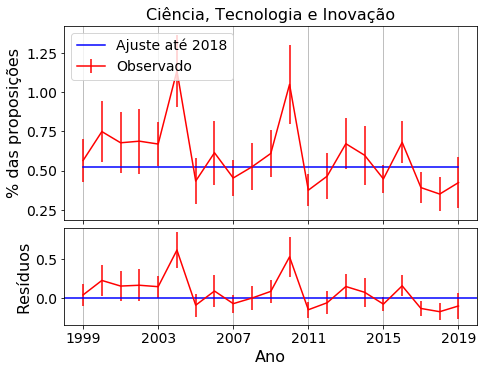

In [169]:
fitNplot(4,0)

### Lixo

In [ ]:
# Evolução da fração de proposições com aquele tema:
i=6
nByAno = nByAnoTema.loc[nByAnoTema.tema==listaTemas[i]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='r-')
pl.title(listaTemas[i])
pl.xticks(np.arange(1987,2020,4))
pl.grid(axis='x')
pl.xlabel('Ano')
pl.ylabel(u'% das proposições')
#pl.ylim([0,10])
pl.show()

In [ ]:
# Decomposição sazonal, não funciona:
from statsmodels.tsa.seasonal import seasonal_decompose
i=6
temporal = nByAnoTema.loc[(nByAnoTema.ano>=1999) & (nByAnoTema.tema==listaTemas[i])].set_index('ano')['frac']
temporal.index = pd.to_datetime(temporal.index, format='%Y')
result = seasonal_decompose(temporal, model='additive')
result.plot()
pl.show()